In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from tqdm import tqdm

from kan_convolutional.KANConv import KAN_Convolutional_Layer

torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import splitfolders as sf
sf.ratio('data',ratio=(0.6,0.2,0.2),seed=42)

Copying files: 5631 files [00:00, 22207.96 files/s]


In [3]:
BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 0.001

In [4]:
data_transformation = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = './output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transformation[x])
                  for x in ['train', 'val', 'test']}
warnings.filterwarnings("ignore")
# Create DataLoader for training and validation datasets
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# Get class names from the dataset
class_names = image_datasets['train'].classes
print(class_names, dataset_sizes)

['cloudy', 'desert', 'green_area', 'water'] {'train': 3378, 'val': 1126, 'test': 1127}


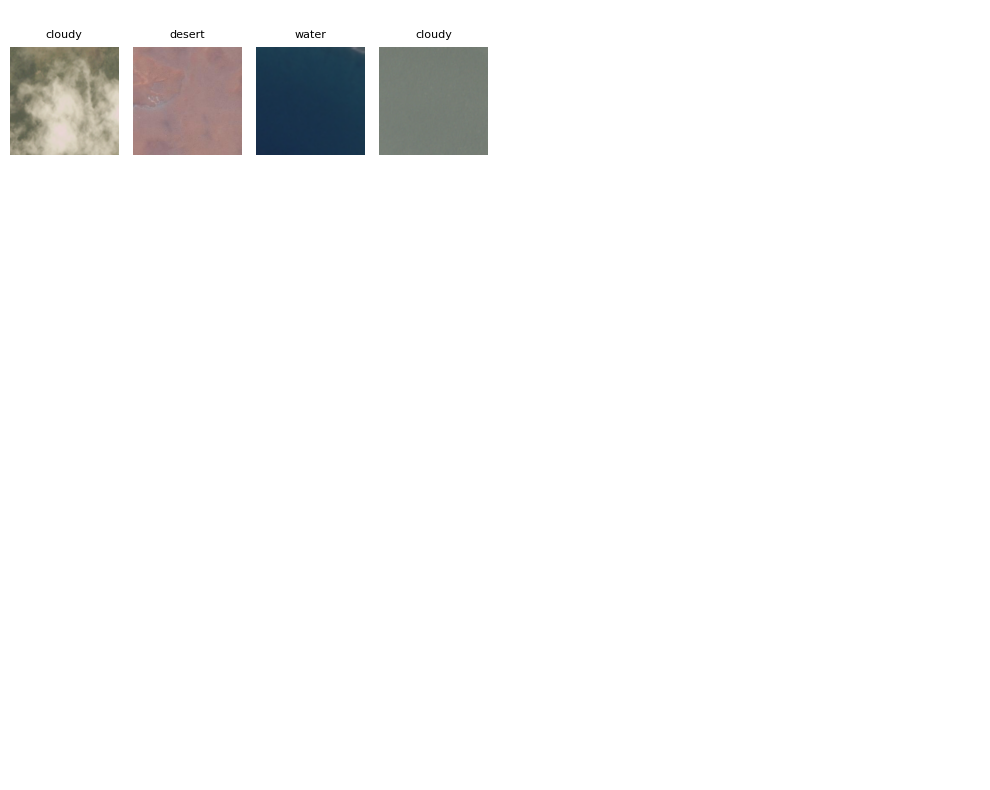

In [7]:
# visualize some images
# function to unnormalize and show an image
def imshow_single(img, ax, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# get a batch of images
inputs, classes = next(iter(dataloaders['train']))

# set up the figure
fig, axes = plt.subplots(4, 8, figsize=(10, 8))  # 4 rows x 8 columns = 32 images
axes = axes.flatten()

# plot each image with its class name
for i in range(len(inputs)):
    imshow_single(inputs[i], axes[i], class_names[classes[i]])

# hide unused subplots if batch size < number of axes
for j in range(len(inputs), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Freeze base layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify final classifier for 4 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelresnet = resnet.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelresnet.fc.parameters(), lr=LEARNING_RATE)

# Early stopping class (same as before)
class EarlyStopping:
    def __init__(self, patience=8):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=8)

# Create DataLoader for training, validation, and test datasets
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

# Training loop
for epoch in range(EPOCHS):
    modelresnet.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = modelresnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    modelresnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelresnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if early_stopper(avg_val_loss, modelresnet):
        print("⏹️ Early stopping triggered.")
        modelresnet.load_state_dict(early_stopper.best_weights)
        break
    
# 🔍 TEST EVALUATION
modelresnet.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = modelresnet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        _, targets = torch.max(labels.data, 1) if labels.ndim == 2 else (labels,)

        total += labels.size(0)
        correct += (predicted == targets).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"\n✅ Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")


100%|██████████| 845/845 [00:14<00:00, 57.23it/s]


Epoch 1/1 - Train Loss: 501.5914 - Val Loss: 0.8598


Testing:   0%|          | 0/282 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
class KANC_MLP(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 5,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 
        
        self.linear1 = nn.Linear(125, 10)
        self.name = f"KANC MLP (Small) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x